**Contexte :**

Les institutions financières doivent **évaluer le risque de défaut de paiement des prêts**.
Des prévisions précises peuvent aider à prendre des décisions éclairées en matière de prêt.
L'apprentissage automatique permet d'analyser les données historiques afin de prévoir les défauts de paiement.

**Objectif:**
- Construire un modèle permettant de prévoir si un prêt fera l'objet d'un défaut de paiement en fonction des données fournies par le demandeur.
- Identifier les facteurs les plus importants contribuant aux défauts de paiement.
- Fournir des recommandations pour atténuer les risques.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Partie :  Exploratoire du jeu de données

In [6]:
# lecture du jeu de données
df = pd.read_csv("loan_default_data.csv")
df.head(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
df.shape

(255347, 18)

In [4]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

### Statistique descriptive sur les variables numériques

In [5]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


### Statistique sur les variables catégorielles

In [7]:
# statistique descriptive sur les variables de type catégorielles
df.describe(include=object)

,LoanID,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
count,255347,255347,255347,255347,255347,255347,255347,255347
unique,255347,4,4,3,2,2,5,2
top,ZTH91CGL0B,Bachelor's,Part-time,Married,Yes,Yes,Business,Yes
freq,1,64366,64161,85302,127677,127742,51298,127701


In [8]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("Variables catégorielles :", list(cat_cols))

Variables catégorielles : ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [9]:
for col in cat_cols:
    print(f"\n{col} :")
    print(df[col].unique())


LoanID :
['I38PQUQS96' 'HPSK72WA7R' 'C1OZ6DPJ8Y' ... 'XQK1UUUNGP' 'JAO28CPL4H'
 'ZTH91CGL0B']

Education :
["Bachelor's" "Master's" 'High School' 'PhD']

EmploymentType :
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']

MaritalStatus :
['Divorced' 'Married' 'Single']

HasMortgage :
['Yes' 'No']

HasDependents :
['Yes' 'No']

LoanPurpose :
['Other' 'Auto' 'Business' 'Home' 'Education']

HasCoSigner :
['Yes' 'No']


Chaque variable catégorielle présente des valeurs uniques correctes.

In [11]:
def plot_repartition(dataset:pd.DataFrame, variable_name:str):
    variable_repartition = dataset[variable_name].value_counts()
    variable_repartition.plot.pie(
        autopct='%1.2f%%', 
        startangle=90)
    plt.show()

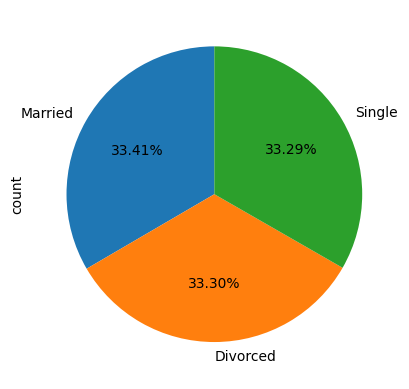

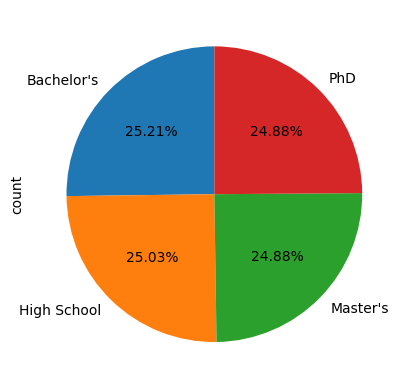

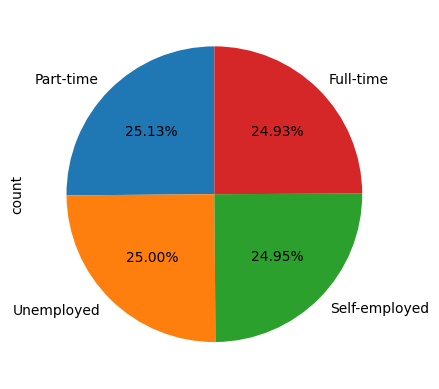

In [12]:
plot_repartition(df, 'MaritalStatus')
plot_repartition(df, 'Education')
plot_repartition(df, 'EmploymentType')

### Gestion de valeurs manquantes

In [10]:
# Valeur Manquante
df.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

### Est-ce que les données sont équilibrées ?

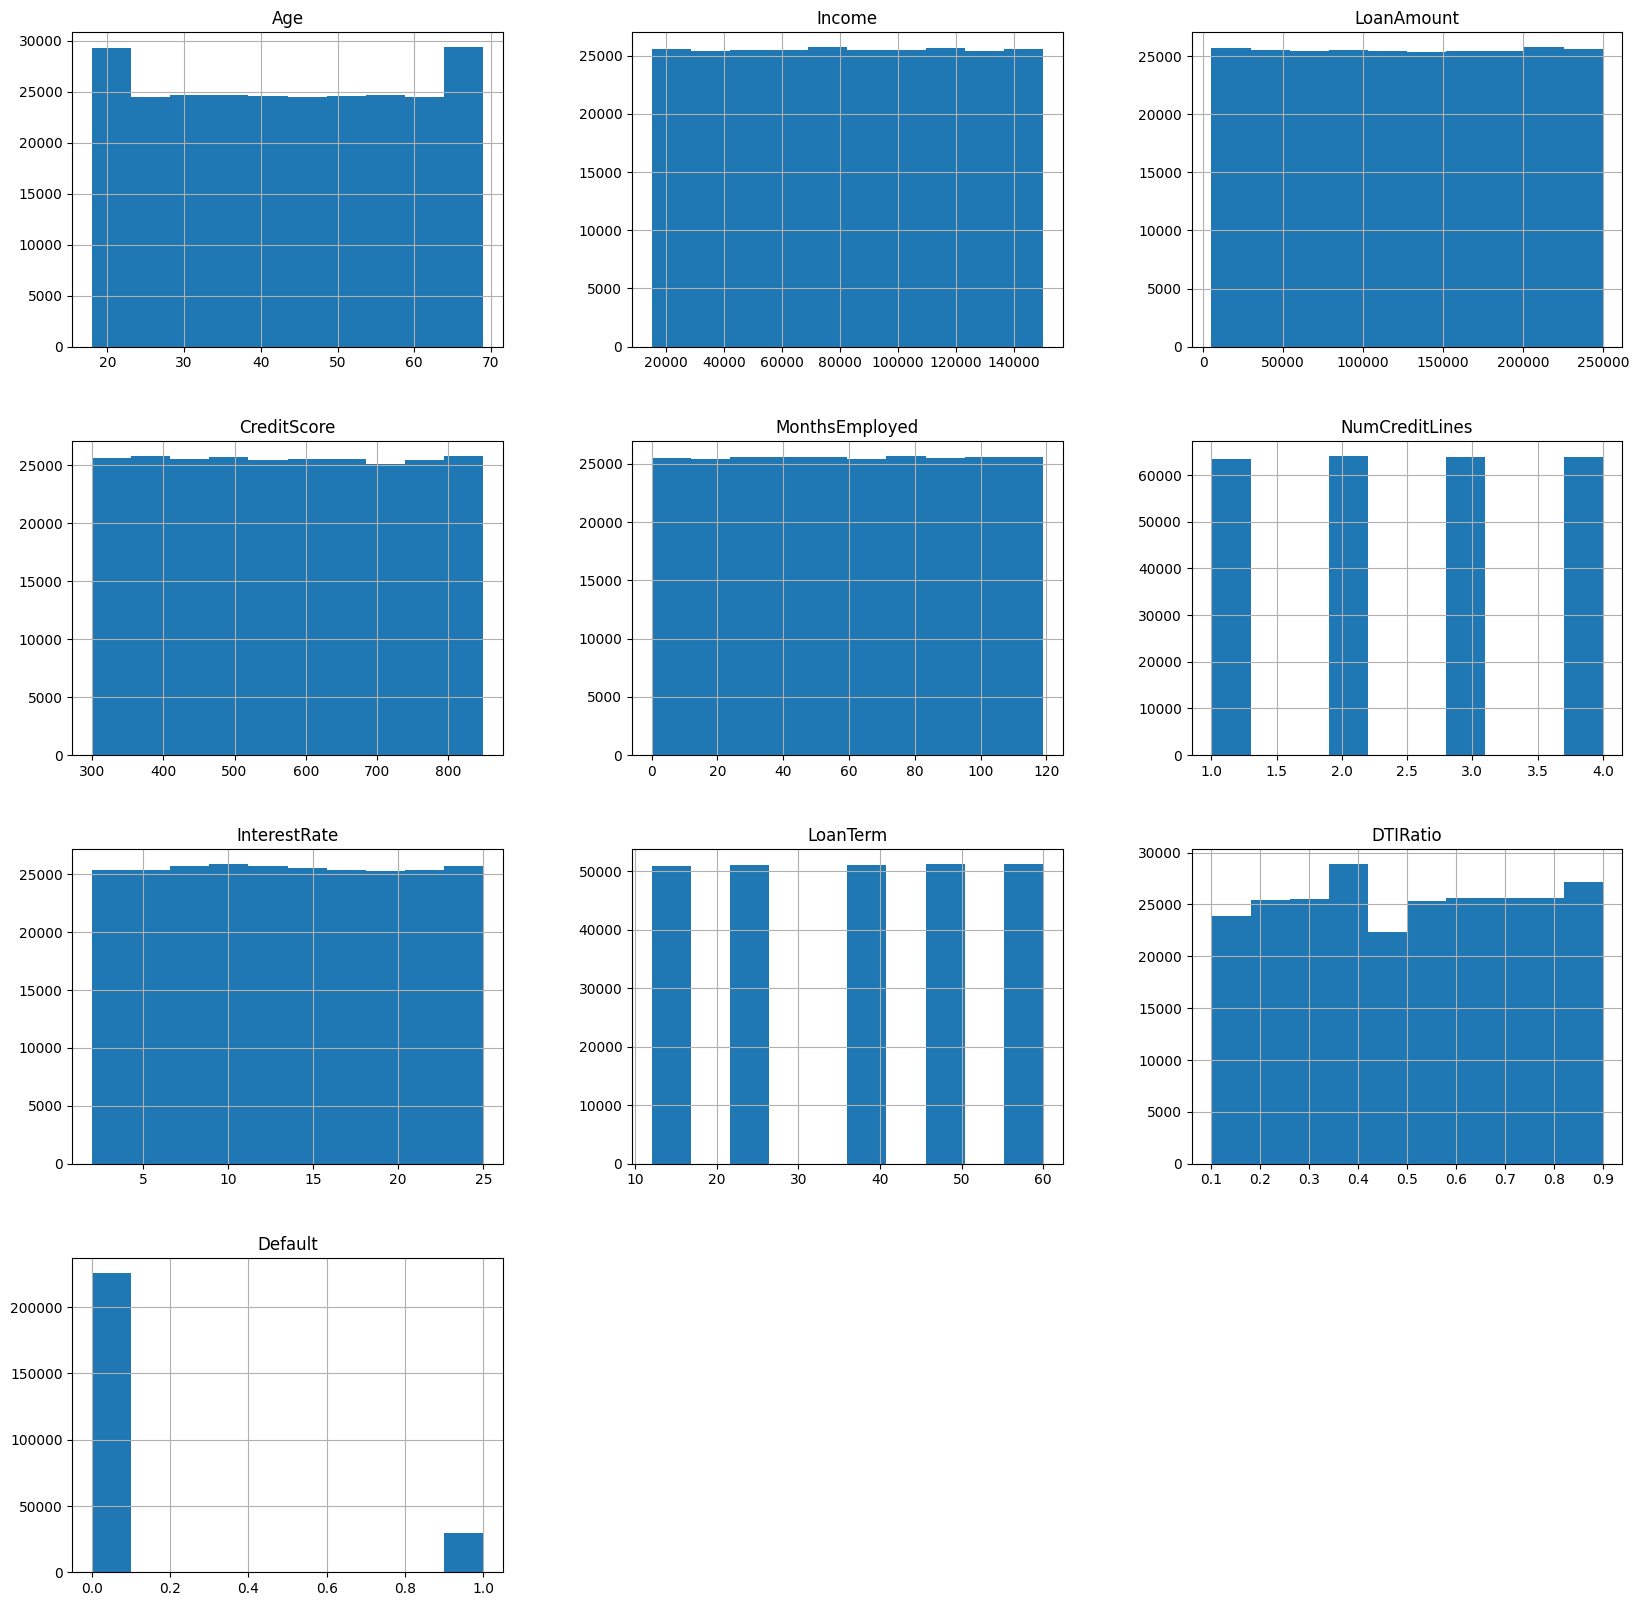

In [13]:
df.hist(figsize=(20, 20));

In [11]:
# Comptage des classes
print(df["Default"].value_counts())

# Pourcentage de chaque classe
print(df["Default"].value_counts(normalize=True) * 100)

Default
0    225694
1     29653
Name: count, dtype: int64
Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64


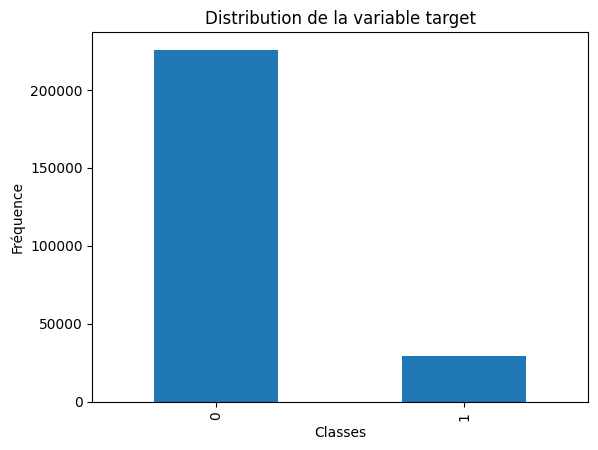

In [12]:
# Vérifier si le dataset est équilibré
# Connaitre la répartition des données en fonction de la target

# Si target est catégorielle
df["Default"].value_counts().plot(kind="bar")
plt.title("Distribution de la variable target")
plt.xlabel("Classes")
plt.ylabel("Fréquence")
plt.show()

Le jeu de données est déséquilibré, car il y'a plus de 0 que de 1. La classe 1 est très minoritaire par rapport à la classe 0. Cela risque de ne pas généraliser.

### Encodage des variables catégorielles

In [14]:
# Variables catégorielle Yes or No en 1 et 0
cols_yes_no = df.columns[df.isin(["Yes", "No"]).any()]
for col in cols_yes_no:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [15]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [16]:
# Encodage Ordinal pour Education
education_order = [["High School", "Bachelor's", "Master's", "PhD"]]
ord_enc = OrdinalEncoder(categories=education_order)
df["Education"] = ord_enc.fit_transform(df[["Education"]])

In [17]:
# One-Hot Encoding pour EmploymentType, MaritalStatus et LoanPurpose

onehot_enc = OneHotEncoder(drop="first", sparse_output=False)

onehot_vars = ["EmploymentType", "MaritalStatus", "LoanPurpose"]

onehot_encoded = onehot_enc.fit_transform(df[onehot_vars])

# Transformer en DataFrame
onehot_df = pd.DataFrame(
    onehot_encoded,
    columns=onehot_enc.get_feature_names_out(onehot_vars)
)

In [18]:
# Fusion
df_final = pd.concat([df.drop(columns=onehot_vars), onehot_df], axis=1)

In [126]:
df_final.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Default,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
df_final.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'HasMortgage', 'HasDependents', 'HasCoSigner',
       'Default', 'EmploymentType_Part-time', 'EmploymentType_Self-employed',
       'EmploymentType_Unemployed', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'LoanPurpose_Business', 'LoanPurpose_Education',
       'LoanPurpose_Home', 'LoanPurpose_Other'],
      dtype='object')

In [19]:
df_final = df_final.drop("LoanID", axis=1)

### Equilibre du jeu de données

In [20]:
X = df_final.drop(columns=['Default'])
y = df_final['Default'].astype(int)

In [131]:
X.head(2)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,...,HasCoSigner,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Visualisation avec PCA et T-SNE

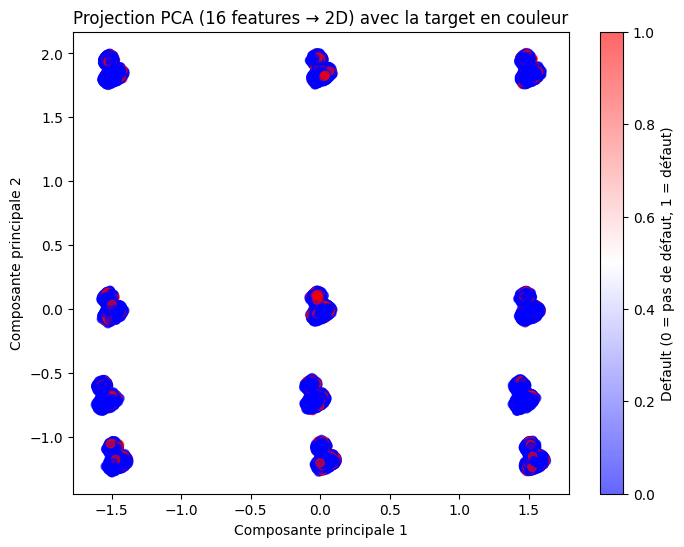

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardiser les données (important pour PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualiser en scatter plot avec target en couleur
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="bwr", alpha=0.6)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection PCA (16 features → 2D) avec la target en couleur")
plt.colorbar(label="Default (0 = pas de défaut, 1 = défaut)")
plt.show()

Realiser l'ACP était dans le but de visualiser les données. En tant donnée que le jeu de données contient plus de 16 caractériqtiques et humainement parlant, on ne peut pas les visualiser pour voir les relations entre les varaibles alors ACP permet de reduire la dimension du jeu de données en projectant les données sur une surface (plan) en conservant le maximum d'information. Cependant, ce graphique ne donne pas d'information pertinente pour comprendre comment les classes minoritaire et majpritaire chevauchent. 

In [132]:
from sklearn.manifold import TSNE

e:\Formation_Data_Analystic\ML2_Lina\projet\sda_ML\my_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


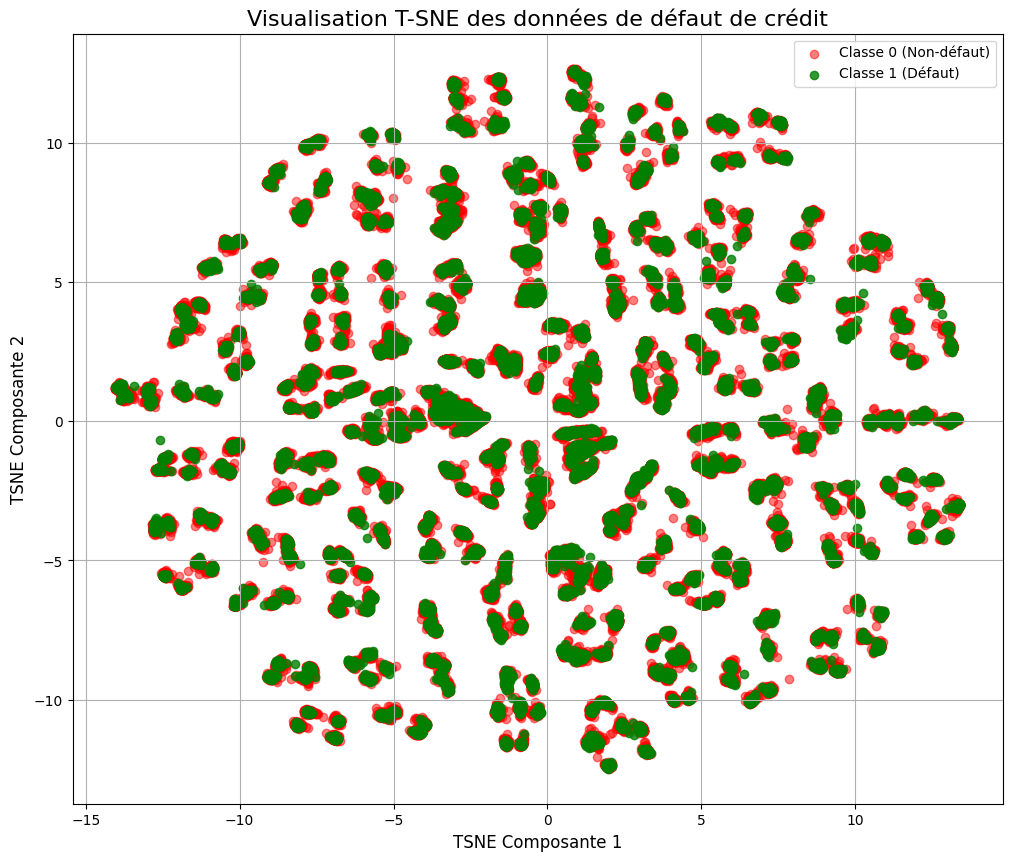

In [133]:
# Standardiser les données (important pour PCA)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 4. Création d'un DataFrame pour la visualisation
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['target'] = y

# 5. Création du nuage de points avec les classes colorées
plt.figure(figsize=(12, 10))

# Séparation des classes pour la visualisation
df_class_0 = df_tsne[df_tsne['target'] == 0]
df_class_1 = df_tsne[df_tsne['target'] == 1]

# Affichage des points de chaque classe
plt.scatter(df_class_0['TSNE1'], df_class_0['TSNE2'], c='red', alpha=0.5, label='Classe 0 (Non-défaut)')
plt.scatter(df_class_1['TSNE1'], df_class_1['TSNE2'], c='green', alpha=0.8, label='Classe 1 (Défaut)')

plt.title('Visualisation T-SNE des données de défaut de crédit', fontsize=16)
plt.xlabel('TSNE Composante 1', fontsize=12)
plt.ylabel('TSNE Composante 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### EQUILIBRER LE JEU DE DONNEES

##### Echantillonage aléatoire

In [57]:
# ECHANTILLONNAGE ALEATOIRE
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print("Avant rééchantillonnage :", y.value_counts())
print("Après rééchantillonnage :", y_res.value_counts())


Avant rééchantillonnage : Default
0    225694
1     29653
Name: count, dtype: int64
Après rééchantillonnage : Default
0    29653
1    29653
Name: count, dtype: int64


##### Tomek Link

Suppression des points de la classe majoritaire proche des points de la classe minoritaire

In [58]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tom, y_tom = tl.fit_resample(X, y)

print("Avant Tomek Links :", y.value_counts())
print("Après Tomek Links :", y_tom.value_counts())

Avant Tomek Links : Default
0    225694
1     29653
Name: count, dtype: int64
Après Tomek Links : Default
0    210636
1     29653
Name: count, dtype: int64


On constate que le jeu de données demeurent encore déséquilibré. l'hypothèse serait vu l'étendu des caractéristques, les données de la classe minoritaire sont très eparpillées de celles de la classe majoritaire. D'où l'agorithme n'a pas pu selectionner et supprimer les plus proches voisins des points de la classe minoritaire.

##### Smote

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Application de la méthode SMOTE
# L'objet SMOTE va générer des échantillons synthétiques pour la classe minoritaire
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Affichage de la distribution des classes après SMOTE
print("Distribution des classes après SMOTE :")
print(Counter(y_smote))


Distribution des classes après SMOTE :
Counter({0: 225694, 1: 225694})


## Partie 2 :  Construction du modèle

### CART: Arbre de décision

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [24]:
# Instancier les données
clf = DecisionTreeClassifier(random_state=42)

##### CAS DES VARIABLES X_res et y_res

In [136]:
# A faire avec les données équilibrées
N_SUBSETS = 10
tree_scores = cross_val_score(clf, X_res, y_res, cv=N_SUBSETS)
tree_scores

array([0.57595684, 0.5958523 , 0.5838813 , 0.58489294, 0.58168943,
       0.59062553, 0.58650927, 0.5856661 , 0.59342327, 0.58010118])

In [137]:
# A faire avec les données équilibrées
N_SUBSETS = 10
tree_scores = cross_val_score(clf, X_smote, y_smote, cv=N_SUBSETS)
tree_scores

array([0.54214759, 0.81366446, 0.91047653, 0.91240391, 0.91568267,
       0.91233745, 0.91373314, 0.91125191, 0.91244628, 0.909965  ])

On constate que les données équilibrées avec la méthode SMOTE, ont eu un bon score par rapport aux données équilibrées avec la méthode d'échantillonage aléatoire

#### Cas avec des données déséquilibrées

Ce code ci dessous permet de trouver les bons hyperparamètres pour ensuite entrainer le modèle

In [88]:
X.head(2)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,...,HasCoSigner,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,56,85994,50587,520,80,4,15.23,36,0.44,1.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,69,50432,124440,458,15,1,4.81,60,0.68,2.0,...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [89]:
y.head(2)

0    0
1    0
Name: Default, dtype: int64

In [ ]:

# Définition de l'espace des hyperparamètres à tester
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced'],
    'random_state': 42
}

# Définition du modèle
cart = DecisionTreeClassifier(random_state=42)

# Utilisation de la validation croisée stratifiée
# C'est crucial pour les datasets déséquilibrés
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lancement de la recherche en grille
# L'évaluation sera basée sur le 'f1_score' car la 'accuracy' est trompeuse sur les datasets déséquilibrés
grid_search = GridSearchCV(estimator=cart, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Affichage des meilleurs hyperparamètres et du score
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur F1-score : {:.4f}".format(grid_search.best_score_))

# Utilisation du meilleur modèle pour les prédictions
best_cart_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs hyperparamètres :  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur F1-score : 0.3157


Le résultat F1-score de 0.3157 suggère qu'au moins l'une de ces deux métriques (ou les deux) est très faible.
Cela est causé par le déséquilibre des classes ce qui entrainera que le modèle ne sera pas fiable pour la prédiction,


D'où il n'est pas fort utile de construire un modèle de ML avec ce déséquilibre de données

#### Cas des données X_smote et y_smote

In [140]:
tree_scores_stats = pd.Series(tree_scores).describe()
tree_scores_stats

count    10.000000
mean      0.865411
std       0.117747
min       0.542148
25%       0.910093
50%       0.911795
75%       0.912436
max       0.915683
dtype: float64

In [25]:
# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)


In [142]:
# Entrainement du modèle
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [147]:
feature_names = X_train.columns
feature_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [148]:
feature_importances

Age                             0.099838
Income                          0.052140
LoanAmount                      0.047350
CreditScore                     0.031600
MonthsEmployed                  0.036583
NumCreditLines                  0.009287
InterestRate                    0.054298
LoanTerm                        0.015038
DTIRatio                        0.027845
Education                       0.128884
HasMortgage                     0.019669
HasDependents                   0.056990
HasCoSigner                     0.082229
EmploymentType_Part-time        0.025064
EmploymentType_Self-employed    0.028061
EmploymentType_Unemployed       0.081324
MaritalStatus_Married           0.138349
MaritalStatus_Single            0.025883
LoanPurpose_Business            0.010513
LoanPurpose_Education           0.010884
LoanPurpose_Home                0.010199
LoanPurpose_Other               0.007973
dtype: float64

In [149]:
# TRIER la série Pandas par ordre décroissant
sorted_importances = feature_importances.sort_values(ascending=False)

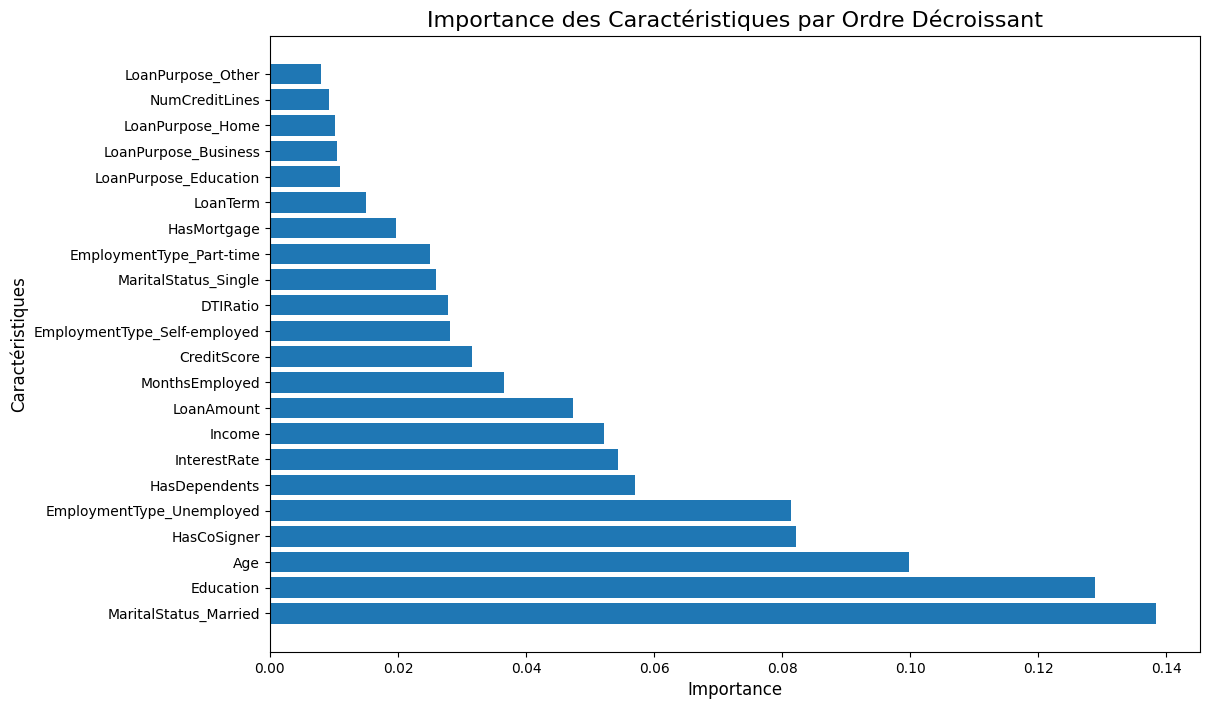

In [150]:

# Créer le graphique à barres avec les données triées
plt.figure(figsize=(12, 8))
plt.barh(sorted_importances.index, sorted_importances.values)

# Ajouter des étiquettes et un titre
plt.title('Importance des Caractéristiques par Ordre Décroissant', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Caractéristiques', fontsize=12)
plt.show()

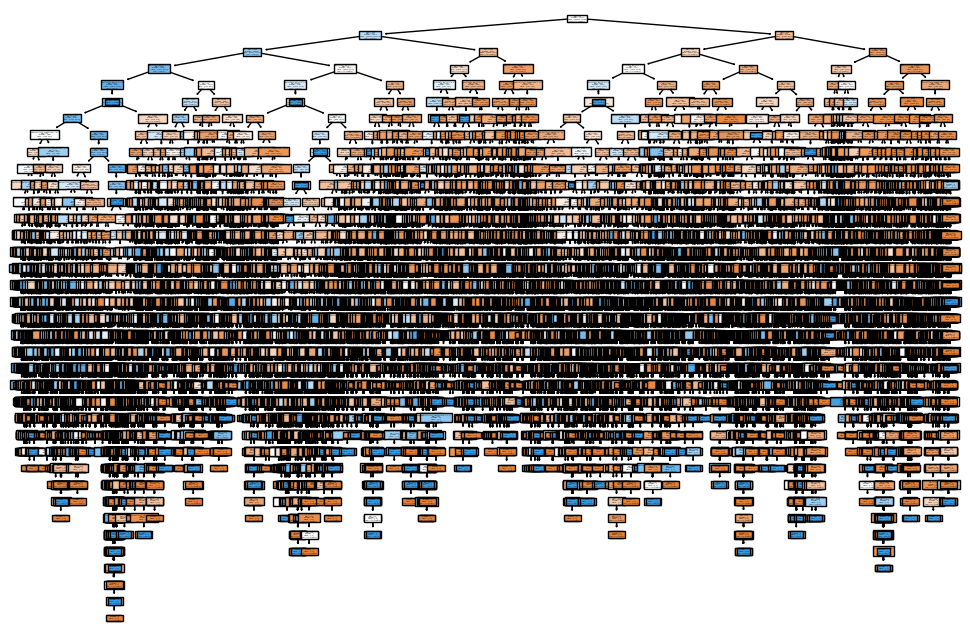

In [152]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(clf,
         feature_names=feature_names, # C'est ici que l'on passe la liste des noms des colonnes
         class_names=['non-default (0)', 'default(1)'],
        filled=True)
plt.show()

C'est très illistre et complexe à comprendre et interpréter

##### Une Approche pour réduire la profondeur de l'arbre (parcimonie)

In [154]:
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
)

In [156]:
N_SUBSETS = 10
tree_scores_small = cross_val_score(clf, X_smote, y_smote, cv=N_SUBSETS)
tree_scores_small

array([0.56173154, 0.69122045, 0.74509847, 0.7425951 , 0.74024679,
       0.74241786, 0.74423448, 0.74210771, 0.74309894, 0.74327618])

In [157]:
tree_scores_small_stats = pd.Series(tree_scores_small).describe()
tree_scores_small_stats

count    10.000000
mean      0.719603
std       0.057812
min       0.561732
25%       0.740712
50%       0.742506
75%       0.743232
max       0.745098
dtype: float64

In [159]:
# Entrainement du modèle
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

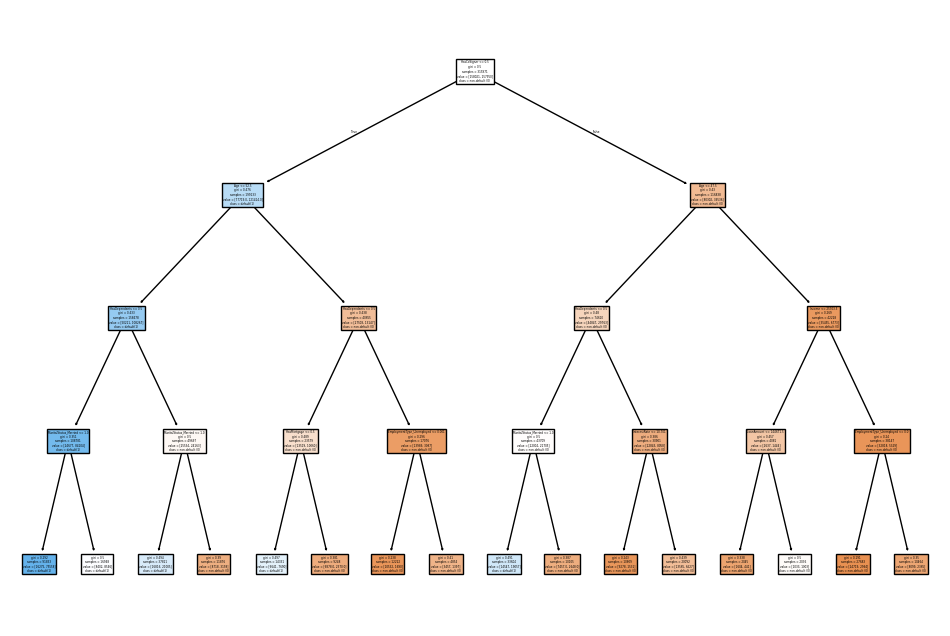

In [160]:
plt.figure(figsize=(12, 8))
plot_tree(clf,
         feature_names=feature_names, # C'est ici que l'on passe la liste des noms des colonnes
         class_names=['non-default (0)', 'default(1)'],
        filled=True)
plt.show()

In [161]:
# Evaluate the model performances

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f'Train perf: {round(score_train, 3 )* 100}%')
print(f'Test perf: {round(score_test, 3) * 100}%')

Train perf: 71.89999999999999%
Test perf: 71.7%


In [162]:
y_pred = clf.predict(X_test)

In [163]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("F1-score : ", f1_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))
print("Accuracy : ", classification_report(y_test, y_pred))

Accuracy :  0.7167563895227335
F1-score :  0.7467147404149662
Recall :  0.8345978979688238
Accuracy :                precision    recall  f1-score   support

           0       0.78      0.60      0.68     67673
           1       0.68      0.83      0.75     67744

    accuracy                           0.72    135417
   macro avg       0.73      0.72      0.71    135417
weighted avg       0.73      0.72      0.71    135417



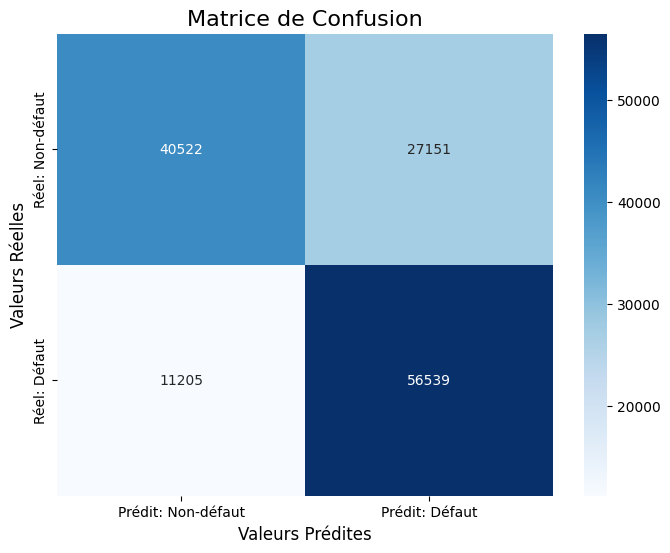

In [164]:
# 5. Calcul de la matrice de confusion
# La matrice de confusion est un tableau (array) NumPy
cm = confusion_matrix(y_test, y_pred)

# 6. Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, # Afficher les valeurs numériques dans les cellules
            fmt='d',    # Formater les nombres en entiers
            cmap='Blues', # Utiliser un dégradé de bleu
            xticklabels=['Prédit: Non-défaut', 'Prédit: Défaut'],
            yticklabels=['Réel: Non-défaut', 'Réel: Défaut'])

plt.title('Matrice de Confusion', fontsize=16)
plt.ylabel('Valeurs Réelles', fontsize=12)
plt.xlabel('Valeurs Prédites', fontsize=12)
plt.show()

#### Performance: Grid-Search

In [29]:
from sklearn.model_selection import GridSearchCV

In [31]:
# Définition de la grille d'hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,4, 5, 6, 7],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [1, 3, 5, 'sqrt', 'log2'],
    'random_state' : [42]
}

In [ ]:
# GridSearchCV
clf_gs = GridSearchCV(clf, param_grid)
clf_gs.fit(X_train, y_train)

In [ ]:
#  Résultats des meilleurs hyperparametres
params_best = clf_gs.best_estimator_.get_params()
params_best

# print("Meilleurs hyperparamètres trouvés :")
# print(grid_search.best_params_)
# # Évaluation sur le jeu de test
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

In [ ]:
cv_results = pd.DataFrame(clf_gs.cv_results_)
cv_results.sort_values(by='rank_test_score').iloc[0]

In [ ]:
# Modele CART avec les meilleurs parametres
clf_best = DecisionTreeClassifier(**params_best)

In [ ]:
tree_scores_essentials_small_best = cross_val_score(clf_best, X, y, cv=N_SUBSETS)
tree_scores_essentials_small_best

In [ ]:
print("\nMeilleure précision en cross-validation :")
print(grid_search.best_score_)

# 7. Évaluation sur le jeu de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Evaluate the model performances

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f'Train perf: {round(score_train, 3 )* 100}%')
print(f'Test perf: {round(score_test, 3) * 100}%')

In [ ]:
# Evaluation
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("F1-score : ", f1_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred))
print("Accuracy : ", classification_report(y_test, y_pred))

## Comparaison avec plusieurs modèles

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [3]:
classifiers = [
    KNeighborsClassifier,
    SVC,
    RandomForestClassifier,
]

In [ ]:
from sklearn.model_selection import KFold

# Define models and results dictionary
models_scores = {}

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
for model in classifiers:
    # Instanciate the model
    modele = model()
    
    # Perform k-fold cross-validation
    scores = cross_val_score(modele, X_train, y_train, cv=kf, scoring='accuracy')
    
    # Store the mean score
    models_scores[model.__name__] = scores.mean().round(2)

In [ ]:
# Résultat
models_scores